In [1]:
%load_ext autoreload
%autoreload 2

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from kcwi_util_modified import register_sauron_colormap
from kcwi_util_modified import visualization
from kcwi_util_modified import get_datacube
from kcwi_util_modified import ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift
from kcwi_util_modified import remove_quasar_from_galaxy_deredshift
from kcwi_util_modified import find_nearest
from kcwi_util_modified import SN_CaHK
from kcwi_util_modified import select_region
from kcwi_util_modified import voronoi_binning
from kcwi_util_modified import get_voronoi_binning_data
from kcwi_util_modified import get_velocity_dispersion_deredshift
from kcwi_util_modified import kinematics_map
from kcwi_util_modified import stellar_type
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import pandas as pd

from specim.specfuncs import spec1d
register_sauron_colormap()

In [2]:
import ppxf

In [3]:
ppxf.__version__

'8.1.0'

### The lens spectra is extracted summing the light with a circular aperture of radius 0.5 arcsec. The quasar spectra are from the brightest pixels in image A, B and C.

In [4]:
libary_dir = '../../kcwi_extractions/all_dr2_fits'

#data directory
dir = "../../kcwi_extractions/extracted_dispersions/"

#KCWI mosaic datacube
name = "KCWI_RXJ1131_icubes_mosaic_0.1457"

#spectrum from the lens center
#spectrum_aperture1 = dir + 'lens.fits' # single pixel
spectrum_aperture = dir + 'lens_central_area.fits' # pixels containing an area with radius 0.5 arcsec


#spectrum from the quasar center
quasar_spectrum_A  = dir + 'quasar_A.fits'
quasar_spectrum_B  = dir + 'quasar_B.fits'
quasar_spectrum_C  = dir + 'quasar_C.fits'

#redshift of the lens
z = 0.295
## R=3600. spectral resolution is ~ 1.42 using observed wavelength 5115 (restframe 3950 Ang) 
FWHM_gal = 1.42
FWHM_tem_xshooter = 0.41 ## R=9700 and wavelength 5115/(1+z) or 3949.81 Ang
noise = 0.014 ## initial estimate of the noise
degree = 3 # degree of the additive Legendre polynomial in ppxf
T_exp = 266 * 60 # the exposure time in second for the KCWI datasets.
wave_min = 0.34  # restframe wavelength in micrometer
wave_max = 0.43
velscale_ratio = 2

### Check the spectra

In [5]:
lens_sp = spec1d.Spec1d(spectrum_aperture, informat='fitsflux', trimsec=[2150, -735])


Reading spectrum from ../../kcwi_extractions/extracted_dispersions/lens_central_area.fits
Expected file format: fitsflux
 Spectrum Start:  4404.00
 Spectrum End:     5568.50
 Dispersion (1st pixel):   0.50
 Dispersion (average):      0.50




Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       4856.25
[Fe VII]      3761.40       4871.01
H-iota        3770.00       4882.15
H-theta       3797.00       4917.11
H-eta         3835.00       4966.32
CN bandhd     3883.00       5028.48
CaII K        3933.67       5094.10
CaII H        3968.47       5139.17
H-delta       4101.00       5310.80



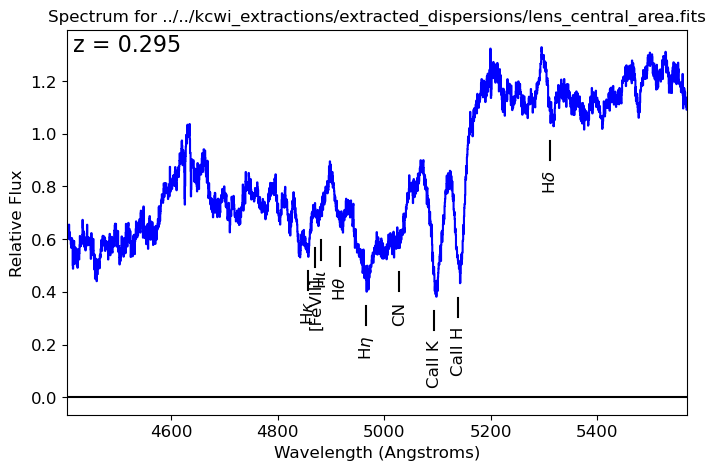

In [6]:
fg = plt.figure(figsize=(8, 5))
lens_sp.smooth(1, fig=fg)
lens_sp.mark_lines('abs', z=0.295, usesmooth=True)

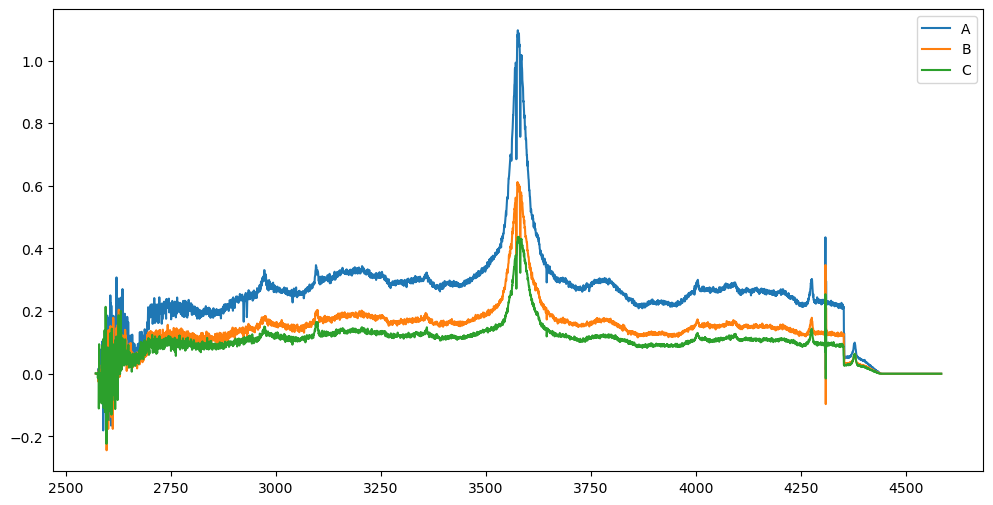

In [7]:
plt.figure(figsize=(12, 6))
hd = fits.open(quasar_spectrum_A)[0].header
wv = (hd['CRVAL1'] + np.arange(hd['NAXIS1'])* hd['CDELT1'])/(1.295) # restframed in lens redshift
plt.plot(wv, fits.open(quasar_spectrum_A)[0].data, label='A')
plt.plot(wv, fits.open(quasar_spectrum_B)[0].data, label="B")
plt.plot(wv, fits.open(quasar_spectrum_C)[0].data, label="C")
plt.legend()

### Create three global lens template from the full librray (628 stellar templates covering the 'UVB' region of around 529 different stars). These three global templates consist of completely non-overlaping set of stellar templates.

### global_temp1 would be used for kinematics measurement and other two global templates are to calculate systematic uncertainty

In [8]:
temp_all = glob.glob(libary_dir + '/*uvb.fits')

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       229       279
chi2/DOF: 2.348; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 39/629
Formal errors:
     dV    dsigma   dh3      dh4
      13     5.2
Elapsed time in pPXF: 2.06 s


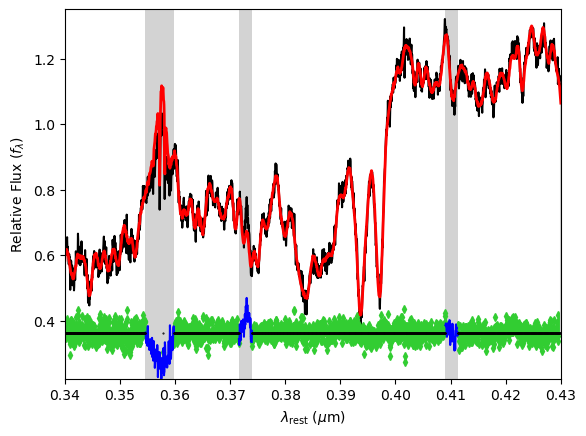

In [9]:
templates1, pp1, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_all)
nTemplates1 = templates1.shape[1]
global_temp1 = templates1 @ pp1.weights[:nTemplates1]

In [10]:
m = pp1.weights[:nTemplates1] >0
tmp = np.array(temp_all)[m]

sorted(tmp)

['../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0072_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0123_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0137_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0172_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0246_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0257_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0263_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0273_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0276_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0401_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0405_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0406_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0419_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0428_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectr

In [11]:
# m = pp1.weights[:nTemplates1] >0
# tmp = np.array(temp_all)[m]
# tmp_set_1 = sorted(tmp)

choice = np.random.choice(range(len(temp_all)), size=int(len(temp_all)/2), replace=False)    
first_set = np.zeros(len(temp_all), dtype=bool)
first_set[choice] = True
second_set = ~first_set

tmp_set_1 = np.array(temp_all)[first_set]

In [12]:
temp_set_new = tmp_set_1

# for fl in temp_all:
#     if fl in tmp_set_1:
#         pass
#     else:
#         temp_set_new.append(fl)
len(temp_set_new)

314

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       243       289
chi2/DOF: 2.424; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 31/315
Formal errors:
     dV    dsigma   dh3      dh4
     9.5     4.4
Elapsed time in pPXF: 1.11 s


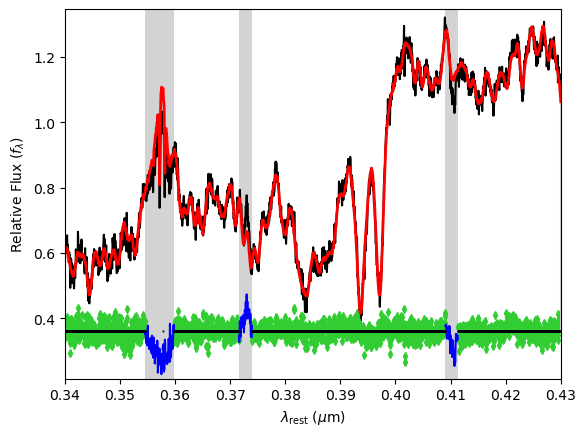

In [13]:
templates2, pp2, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_set_new)
nTemplates2 = templates2.shape[1]
global_temp2 = templates2 @ pp2.weights[:nTemplates2]

In [14]:
m2 = pp2.weights[:nTemplates2] >0
tmp1 = np.array(temp_set_new)[m2]

sorted(tmp1)

['../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0024_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0206_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0257_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0273_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0274_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0277_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0359_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0377_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0397_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0401_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0406_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0419_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0428_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0435_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectr

In [15]:
# sorted(tmp1)
tmp_set_2 = np.array(temp_all)[second_set]

len(tmp_set_2)

314

In [16]:
temp_set_new2 = tmp_set_2 #[]
# for fl in temp_all:
#     if fl in tmp_set_1 or fl in tmp1:
#         pass
#     else:
#         temp_set_new2.append(fl)
len(temp_set_new2)

314

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1378 1379 1380 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       495       280
chi2/DOF: 2.441; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 27/315
Formal errors:
     dV    dsigma   dh3      dh4
     8.3     4.7
Elapsed time in pPXF: 1.24 s


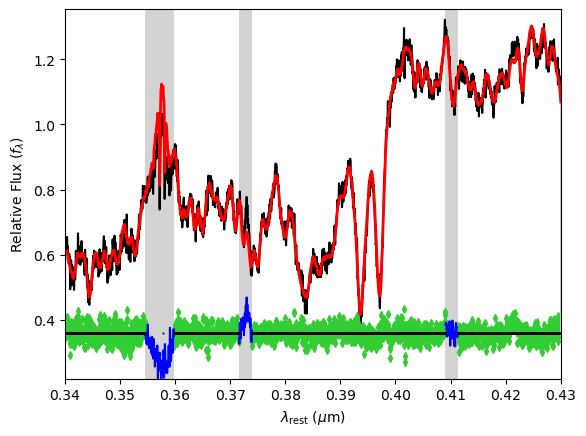

In [17]:
templates3, pp3, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_set_new2)
nTemplates3 = templates3.shape[1]
global_temp3 = templates3 @ pp3.weights[:nTemplates3]

In [18]:
m3 = pp3.weights[:nTemplates3] >0
tmp2 = np.array(temp_set_new2)[m3]
sorted(tmp2)

['../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0072_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0172_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0197_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0205_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0246_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0263_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0276_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0282_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0295_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0351_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0352_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0400_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0443_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0518_uvb.fits',
 '../../kcwi_extractions/all_dr2_fits/xsl_spectr

In [19]:
len(temp_all)

628

In [20]:
df = pd.DataFrame({'weight': pp1.weights[:nTemplates1][m],
                   'names': tmp}
                  )
df.to_csv('template_set_1.csv', index=False)

df = pd.DataFrame({'weight': pp2.weights[:nTemplates2][m2],
                   'names': tmp1}
                  )
df.to_csv('template_set_2.csv', index=False)

df = pd.DataFrame({'weight': pp3.weights[:nTemplates3][m3],
                   'names': tmp2}
                  )
df.to_csv('template_set_3.csv', index=False)

df = pd.DataFrame({'weight': np.ones(len(temp_all))/np.float(len(temp_all)),
                   'names': temp_all}
                  )
df.to_csv('template_set_all.csv', index=False)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_41204/2482505990.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = pd.DataFrame({'weight': np.ones(len(temp_all))/np.float(len(temp_all)),


### Check whether the global templates are completely non-overlaping

In [21]:
set(tmp).intersection(set(tmp)), set(tmp).intersection(set(tmp1)), set(tmp).intersection(set(tmp2))

({'../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0072_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0123_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0137_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0172_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0246_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0257_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0263_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0273_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0276_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0401_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0405_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0406_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0419_uvb.fits',
  '../../kcwi_extractions/all_dr2_fits/xsl_spectrum_X0428_uvb.fits',
  '../../kcwi_extractions/all_dr2_

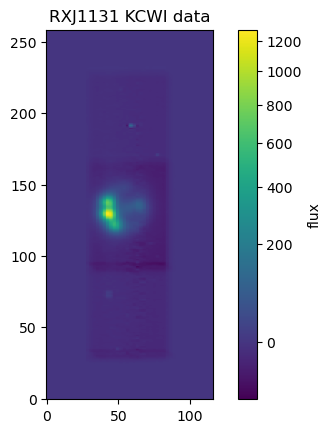

In [22]:
hdu = fits.open(dir+name+'.fits')
visualization(hdu)

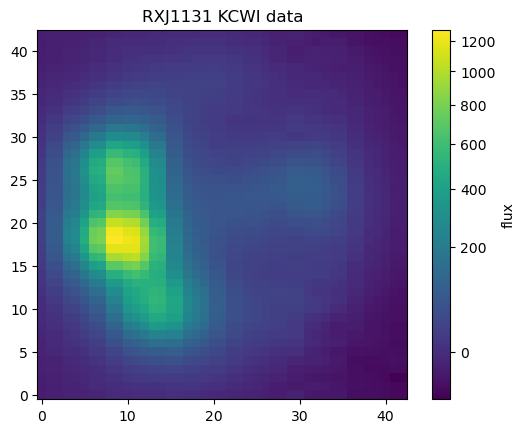

In [23]:
%matplotlib inline

data_crop = fits.open(dir + name + '_crop.fits')
radius_in_pixels = 21
visualization(data_crop)

In [24]:
# image_x = [9, 9, 13, 30, 33]
# image_y = [18, 26, 11, 24, 25]

image_x = np.array([ 9.75440985,  9.48673655, 13.71460203, 31.1065032 ])
image_y = np.array([18.52632387, 26.63888393, 10.89420307, 24.53867802])

sat_x, sat_y = 22.687151464094285, 25.89937713647318
gal_x, gal_y = 23.29113224652393, 22.227448516020196

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_41204/2084253364.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(np.sum(data_crop[0].data, axis=0)), origin='lower');


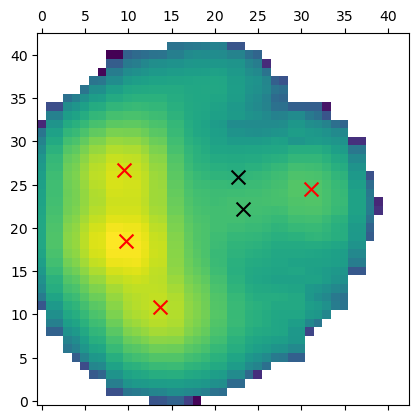

In [25]:
plt.matshow(np.log10(np.sum(data_crop[0].data, axis=0)), origin='lower');
plt.scatter(image_x, image_y, s=100, c='r', marker='x')
plt.scatter(sat_x, sat_y, s=100, c='k', marker='x')
plt.scatter(gal_x, gal_y, s=100, c='k', marker='x');


### loop over the entire cropped data cube to remove the quasar and obtain the noise cube using global_template_1

/Users/ajshajib/miniforge3/lib/python3.10/site-packages/ppxf/capfit.py:898: RuntimeWarning: invalid value encountered in double_scalars
  ratio = actred/prered


CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008558; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000542
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009019; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008915; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000532
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009518; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000432
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

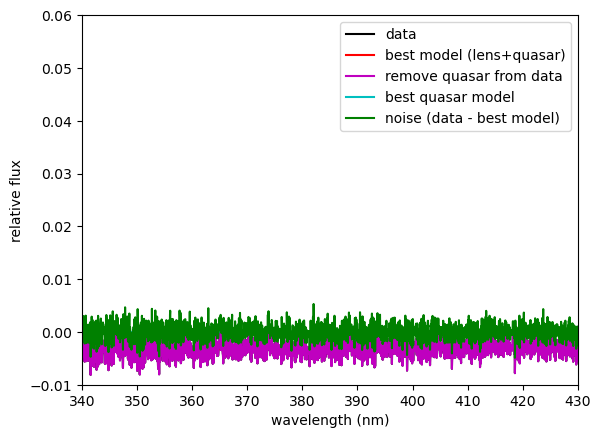

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005452; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008257; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       125         0
chi2/DOF: 0.005460; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000298  0.000961
Formal errors:
     dV    dsigma   dh3      dh4
      66 4.7e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -26         0
chi2/DOF: 0.008864; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000

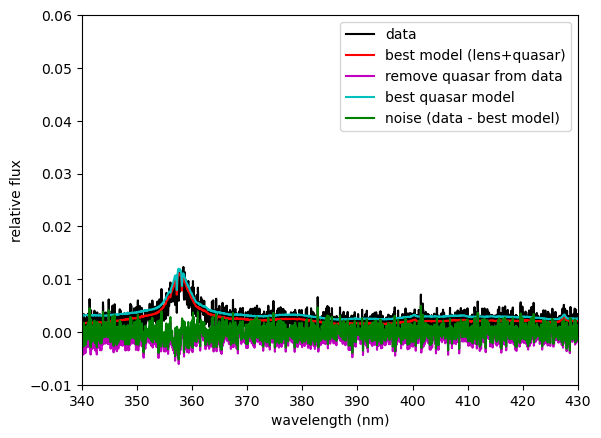

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009670; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00271
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008594; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

 Best Fit:       Vel     sigma
 comp.  0:       179         0
chi2/DOF: 0.006374; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000301         0
Formal errors:
     dV    dsigma   dh3      dh4
      71 3.8e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -367         0
chi2/DOF: 0.007637; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000286  4.46e-05
Formal errors:
     dV    dsigma   dh3      dh4
      78 5.8e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006358; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00103
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009118; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009256; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00263
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006202; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00219
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007878; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005214; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01013; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00639
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007085; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00686
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254874

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008362; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007124; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         

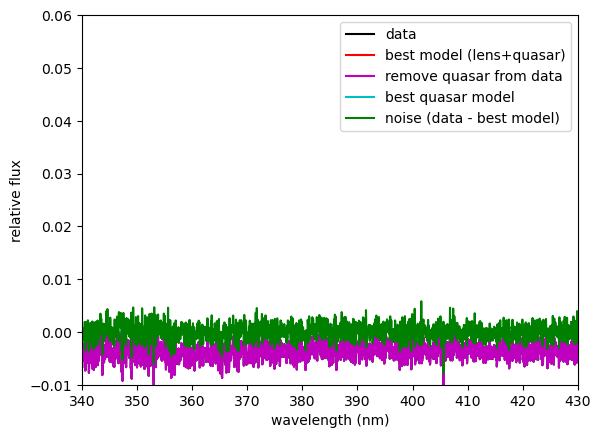

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006670; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008581; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01281; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0122
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01285; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0111
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548743

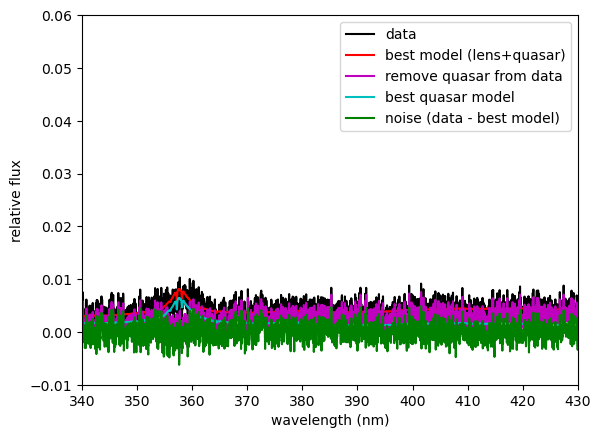

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01005; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00153
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007140; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0

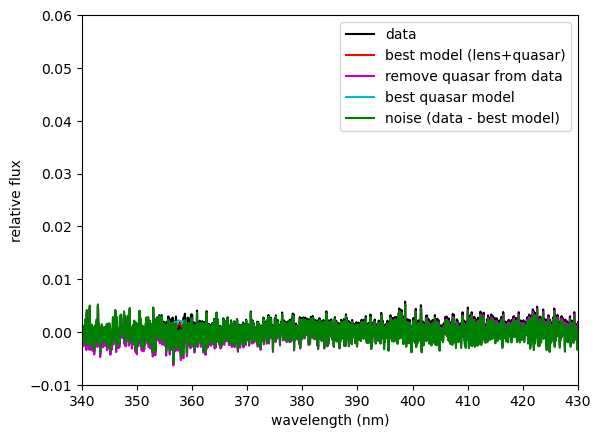

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008499; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00042
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008499; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009427; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00151
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009427; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00151
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01188; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00411
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01038; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00389
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time i

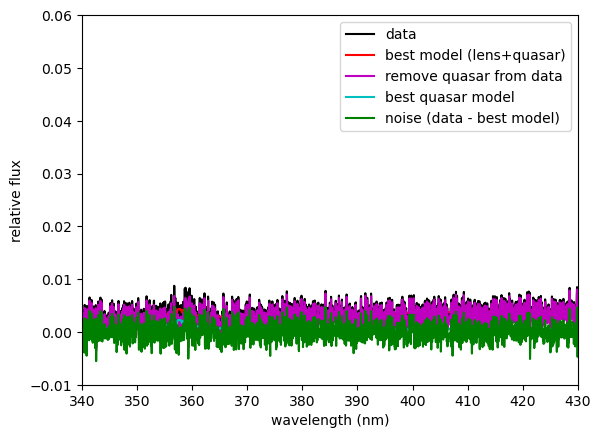

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005457; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  6.21e-06  0.000492
Formal errors:
     dV    dsigma   dh3      dh4
 2.1e+04 2.2e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008770; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007335; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -164        99
chi2/DOF: 0.008236; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000351   0.00127
Formal errors:
     dV    dsigma   dh3      dh4
   2e+02 2.4e+02
Elapsed tim

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01136; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0018
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007727; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005545; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008330; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.04957; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0503
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.04957; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0 

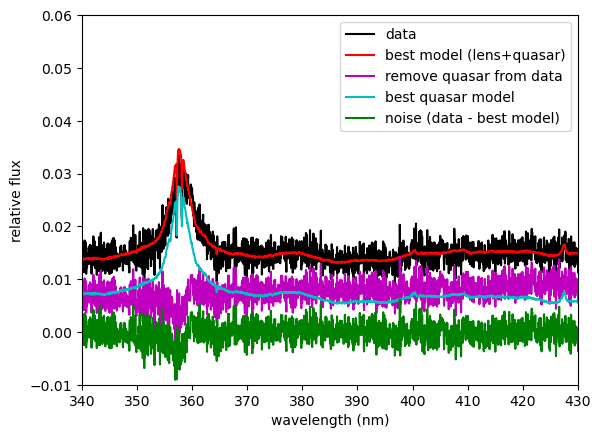

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01191; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00284
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01191; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0 

 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007862; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005145; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.08097; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0706
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.08097; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0706
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time i

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008694; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000103
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007405; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  7.78e-05
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

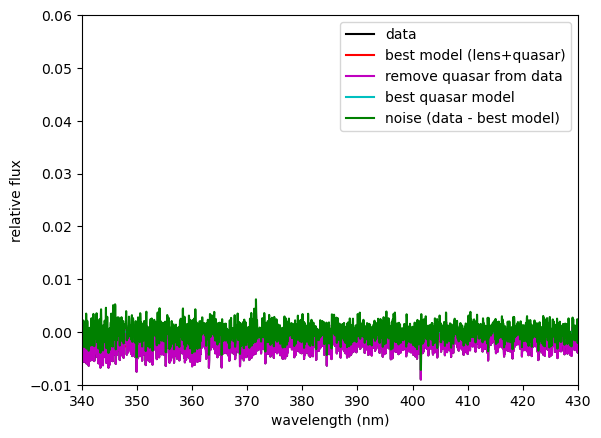

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008429; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006106; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

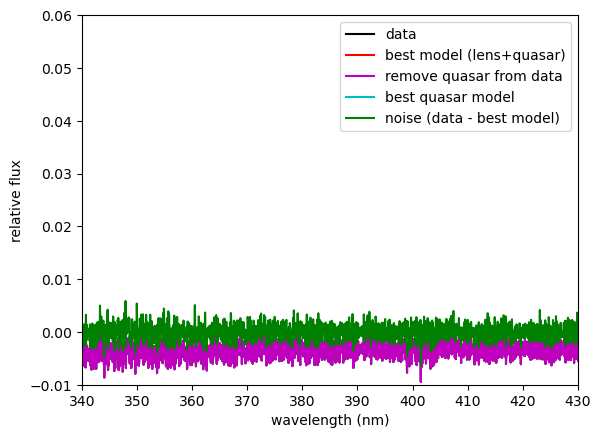

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006379; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008458; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.09415; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0849
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.09415; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0849
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time i

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009816; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000297
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006604; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008083; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0128
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01422; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0188
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time 

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        71       193
chi2/DOF: 0.01608; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00108    0.0101
Formal errors:
     dV    dsigma   dh3      dh4
 1.8e+02 1.8e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        83       186
chi2/DOF: 0.01412; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 15; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00107   0.00953
Formal errors:
     dV    dsigma   dh3      dh4
 1.6e+02 1.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -551         0
chi2/DOF: 0.007094; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000335         0
Formal errors:
     dV    dsigma   dh3      dh4
      66 3.8e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008581; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed tim

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.1818; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.122
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.1698; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   

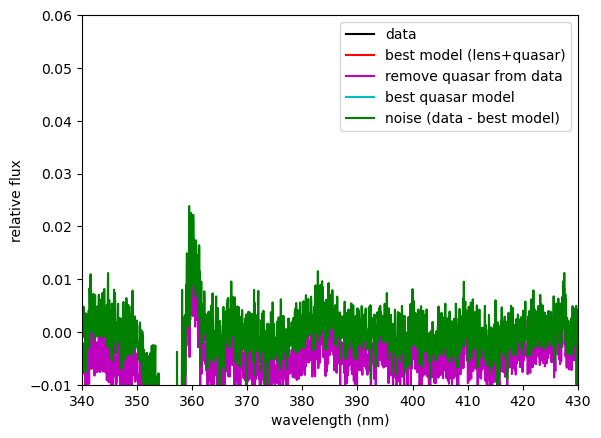

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.09165; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.086
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.03358; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0 

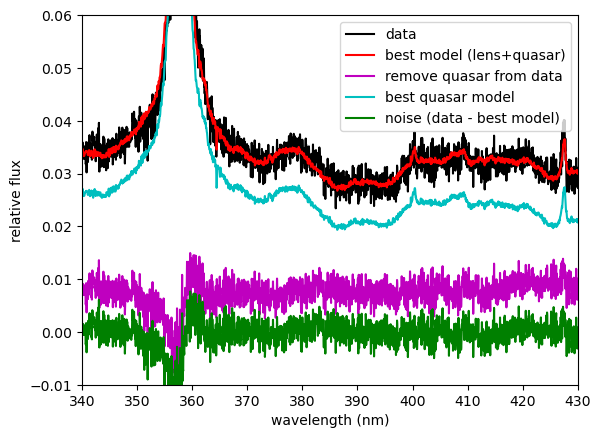

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -147        41
chi2/DOF: 0.01574; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00131    0.0106
Formal errors:
     dV    dsigma   dh3      dh4
      48      60
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -141        55
chi2/DOF: 0.01369; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.0013

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        37         0
chi2/DOF: 0.006366; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 27; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000321         0
Formal errors:
     dV    dsigma   dh3      dh4
      66 3.2e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008421; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  4.68e-

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.1357; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0     0.113
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.08052; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  

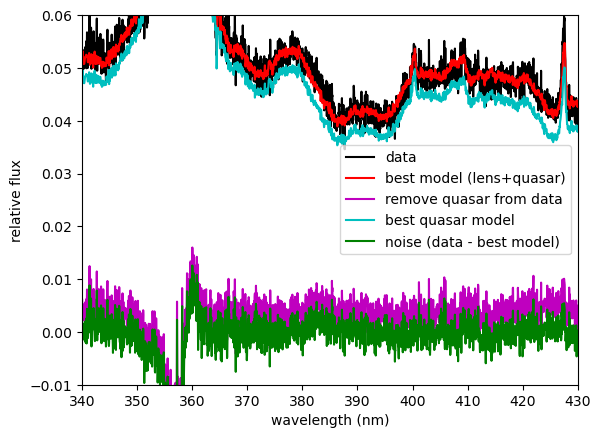

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       306       163
chi2/DOF: 0.02628; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000215    0.0316
Formal errors:
     dV    dsigma   dh3      dh4
 6.6e+02 1.7e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       240         0
chi2/DOF: 0.01471; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 24; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.00093

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -517       237
chi2/DOF: 0.009031; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000571         0
Formal errors:
     dV    dsigma   dh3      dh4
 2.8e+02   3e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -539       242
chi2/DOF: 0.007647; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 19; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000

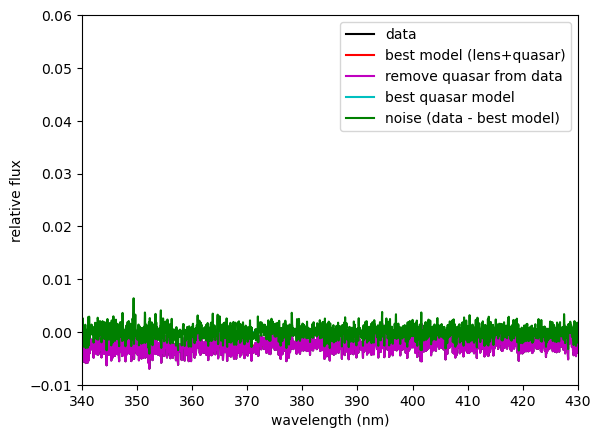

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008409; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007030; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.06665; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0694
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.06665; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        87       241
chi2/DOF: 0.009568; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.002  7.66e-05
Formal errors:
     dV    dsigma   dh3      dh4
      79      84
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -87        52
chi2/DOF: 0.006939; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
   0.001

 Best Fit:       Vel     sigma
 comp.  0:      -782       428
chi2/DOF: 0.01134; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000702    0.0107
Formal errors:
     dV    dsigma   dh3      dh4
 5.6e+02 5.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -158       413
chi2/DOF: 0.01074; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000828    0.0208
Formal errors:
     dV    dsigma   dh3      dh4
   5e+02 4.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254874

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        -1       106
chi2/DOF: 0.02107; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00226    0.0233
Formal errors:
     dV    dsigma   dh3      dh4
      56      67
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        44       150
chi2/DOF: 0.01220; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.0027

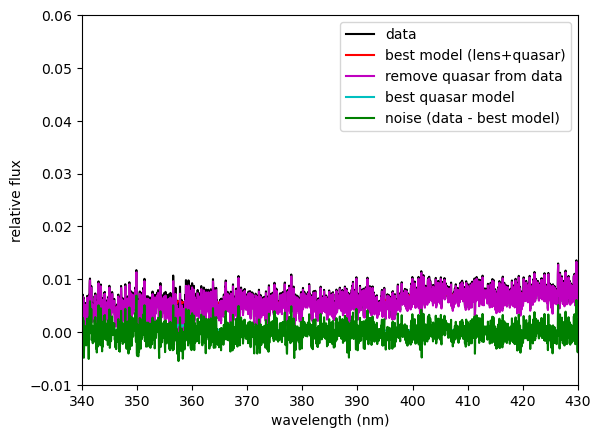

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       218       233
chi2/DOF: 0.006732; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00159  0.000461
Formal errors:
     dV    dsigma   dh3      dh4
      85      91
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       181        78
chi2/DOF: 0.009013; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0

 Best Fit:       Vel     sigma
 comp.  0:      1958       101
chi2/DOF: 0.01790; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 36; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000955    0.0505
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+02 1.6e+02
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.03894; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0766
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254874

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       208       248
chi2/DOF: 0.01017; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00511   0.00095
Formal errors:
     dV    dsigma   dh3      dh4
      34      36
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       204       252
chi2/DOF: 0.008784; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.004

 Best Fit:       Vel     sigma
 comp.  0:      -267         0
chi2/DOF: 0.01364; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000523    0.0158
Formal errors:
     dV    dsigma   dh3      dh4
      60 3.3e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -267         0
chi2/DOF: 0.01364; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000523    0.0158
Formal errors:
     dV    dsigma   dh3      dh4
      60 3.3e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       186       256
chi2/DOF: 0.009640; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00558    0.0123
Formal errors:
     dV    dsigma   dh3      dh4
      32      34
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       195       285
chi2/DOF: 0.01287; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00723   0.00661
Formal errors:
     dV    dsigma   dh3      dh4
      32      34
Elapsed tim

 Best Fit:       Vel     sigma
 comp.  0:      -127       121
chi2/DOF: 0.009701; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
   0.00075         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+02 1.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -127       121
chi2/DOF: 0.009701; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
   0.00075         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+02 1.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254

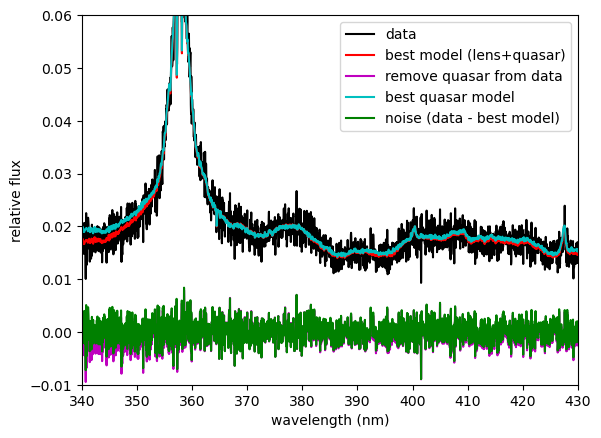

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -77       214
chi2/DOF: 0.01877; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00108    0.0438
Formal errors:
     dV    dsigma   dh3      dh4
 2.2e+02 2.4e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         6        93
chi2/DOF: 0.02864; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00108

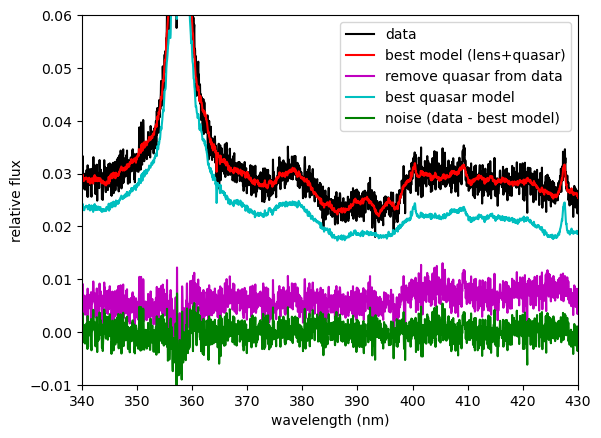

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       182       248
chi2/DOF: 0.01501; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00553    0.0154
Formal errors:
     dV    dsigma   dh3      dh4
      39      42
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       187       275
chi2/DOF: 0.009052; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.007

 Best Fit:       Vel     sigma
 comp.  0:       163       285
chi2/DOF: 0.006886; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00238   0.00106
Formal errors:
     dV    dsigma   dh3      dh4
      67      71
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       224       179
chi2/DOF: 0.01048; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00204   0.00031
Formal errors:
     dV    dsigma   dh3      dh4
      71      77
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -418         0
chi2/DOF: 2.005e-13; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 31; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  3.59e-09     0.261
Formal errors:
     dV    dsigma   dh3      dh4
      33 2.2e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -418         0
chi2/DOF: 2.005e-13; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 31; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  3.59e-09     0.261
Formal errors:
     dV    dsigma   dh3      dh4
      33 2.2e+03
Elapsed 

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       173       290
chi2/DOF: 0.008143; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0154   0.00232
Formal errors:
     dV    dsigma   dh3      dh4
      12      13
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       171       285
chi2/DOF: 0.01088; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0153    0.0021
Formal errors:
     dV    dsigma   dh3      dh4
      14      15
Elapsed time in pPXF: 0.01 s
CRVA

 Best Fit:       Vel     sigma
 comp.  0:       222         0
chi2/DOF: 0.008990; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000468         0
Formal errors:
     dV    dsigma   dh3      dh4
      54 3.6e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       197         0
chi2/DOF: 0.005696; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000434         0
Formal errors:
     dV    dsigma   dh3      dh4
      46 3.3e+03
Elapsed time in pPXF: 0.01 s


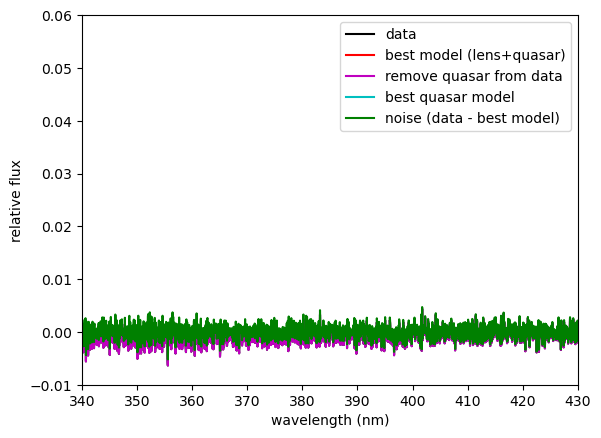

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       159         0
chi2/DOF: 0.008377; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000449         0
Formal errors:
     dV    dsigma   dh3      dh4
      54 3.9e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       149         0
chi2/DOF: 0.007016; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 15; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       137       301
chi2/DOF: 0.01998; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00575    0.0343
Formal errors:
     dV    dsigma   dh3      dh4
      51      55
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       185       265
chi2/DOF: 0.01106; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.0090

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       100       212
chi2/DOF: 0.007257; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00265   0.00333
Formal errors:
     dV    dsigma   dh3      dh4
      48      52
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        33       138
chi2/DOF: 0.01094; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.001

 Best Fit:       Vel     sigma
 comp.  0:      2000      1000
chi2/DOF: 0.06647; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 23; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0065     0.133
Formal errors:
     dV    dsigma   dh3      dh4
   3e+02 3.6e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      1557      1000
chi2/DOF: 0.1238; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00569      0.21
Formal errors:
     dV    dsigma   dh3      dh4
 4.8e+02 5.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254874

 Best Fit:       Vel     sigma
 comp.  0:       186       285
chi2/DOF: 0.01335; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.024   0.00381
Formal errors:
     dV    dsigma   dh3      dh4
     9.9      11
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       186       285
chi2/DOF: 0.01335; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.024   0.00381
Formal errors:
     dV    dsigma   dh3      dh4
     9.9      11
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       137       208
chi2/DOF: 0.005697; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000748  0.000305
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+02 1.6e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       277         0
chi2/DOF: 0.009179; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000

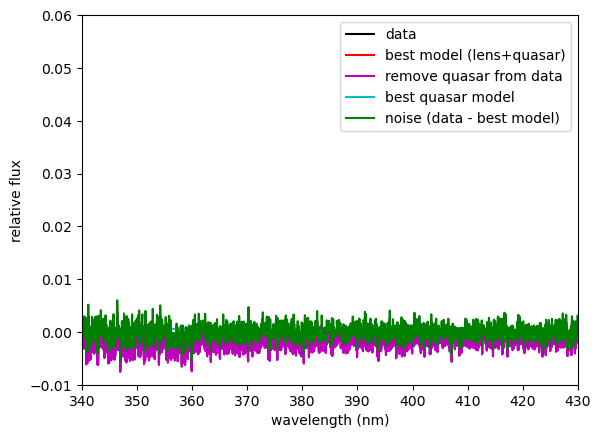

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009902; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00751
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       201       233
chi2/DOF: 0.01319; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000558

 Best Fit:       Vel     sigma
 comp.  0:       252       268
chi2/DOF: 0.01873; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00658    0.0281
Formal errors:
     dV    dsigma   dh3      dh4
      38      41
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       197       277
chi2/DOF: 0.009898; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0107    0.0154
Formal errors:
     dV    dsigma   dh3      dh4
      18      20
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

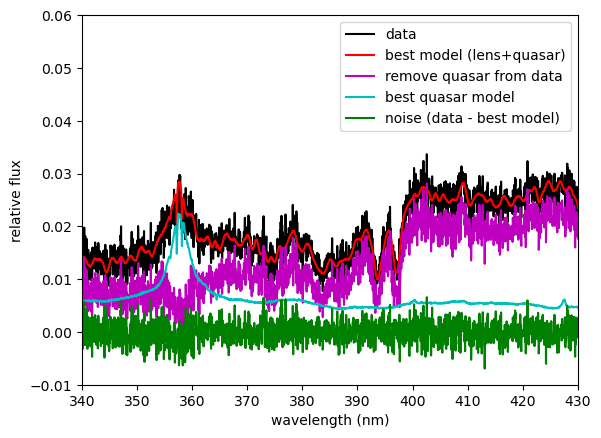

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       180       278
chi2/DOF: 0.01174; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0215   0.00522
Formal errors:
     dV    dsigma   dh3      dh4
      10      11
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       208       280
chi2/DOF: 0.01426; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.026

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       470         0
chi2/DOF: 0.009964; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000967   0.00145
Formal errors:
     dV    dsigma   dh3      dh4
      28 1.9e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       470         0
chi2/DOF: 0.009964; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000967   0.00145
Formal errors:
     dV    dsigma   dh3      dh4
      28 1.9e+03
Elapsed 

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       171       301
chi2/DOF: 0.06696; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00139     0.129
Formal errors:
     dV    dsigma   dh3      dh4
 4.1e+02 4.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.07744; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 7; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00112

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       171       259
chi2/DOF: 0.01285; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0158   0.00697
Formal errors:
     dV    dsigma   dh3      dh4
      13      14
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       171       259
chi2/DOF: 0.01115; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.015

 Best Fit:       Vel     sigma
 comp.  0:      -413        40
chi2/DOF: 0.007489; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000595  1.57e-05
Formal errors:
     dV    dsigma   dh3      dh4
      47      90
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      2000       878
chi2/DOF: 0.01027; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00143   0.00669
Formal errors:
     dV    dsigma   dh3      dh4
   5e+02 6.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

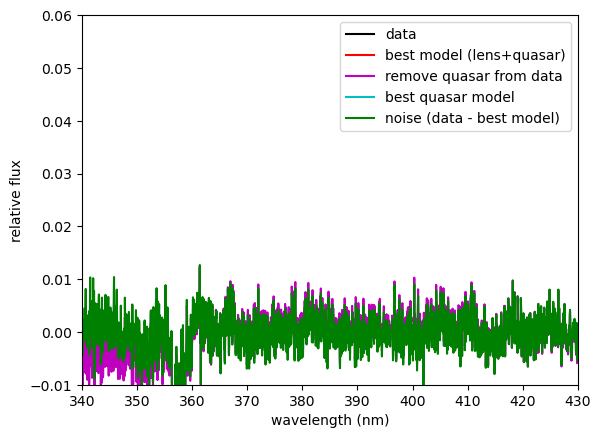

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       446         0
chi2/DOF: 0.07472; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00156     0.129
Formal errors:
     dV    dsigma   dh3      dh4
      47 2.8e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       446         0
chi2/DOF: 0.07472; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.0015

 Best Fit:       Vel     sigma
 comp.  0:       175       277
chi2/DOF: 0.01381; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0282    0.0032
Formal errors:
     dV    dsigma   dh3      dh4
     8.3     8.9
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       173       289
chi2/DOF: 0.009483; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0256   0.00384
Formal errors:
     dV    dsigma   dh3      dh4
     7.9     8.5
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       213       427
chi2/DOF: 0.006823; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00161  0.000477
Formal errors:
     dV    dsigma   dh3      dh4
 1.4e+02 1.5e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       349       474
chi2/DOF: 0.008986; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00157  0.000106
Formal errors:
     dV    dsigma   dh3      dh4
 1.9e+02   2e+02
Elapsed ti

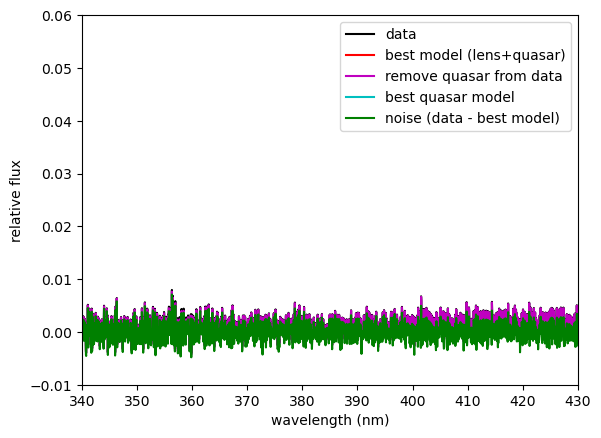

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       480       305
chi2/DOF: 0.005421; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 18; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00122  0.000151
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+02 1.4e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       493         0
chi2/DOF: 0.008813; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 13; Func calls: 41; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.00

 Best Fit:       Vel     sigma
 comp.  0:       531         0
chi2/DOF: 0.05099; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00142     0.103
Formal errors:
     dV    dsigma   dh3      dh4
      43 2.5e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       329       193
chi2/DOF: 0.03661; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00283     0.061
Formal errors:
     dV    dsigma   dh3      dh4
      99 1.1e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

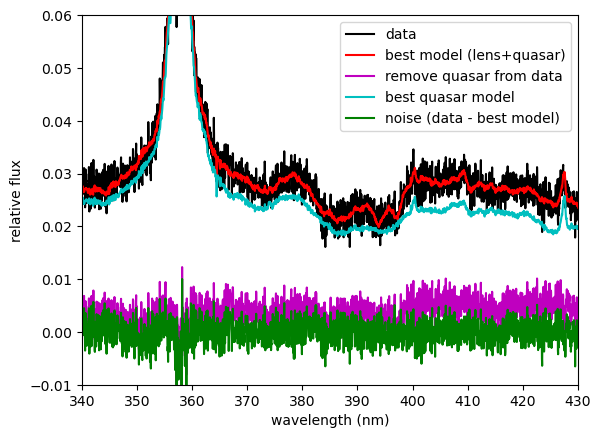

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       211       276
chi2/DOF: 0.009307; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0111    0.0122
Formal errors:
     dV    dsigma   dh3      dh4
      18      19
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       206       280
chi2/DOF: 0.01200; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.01

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       141       173
chi2/DOF: 0.008969; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00245     0.011
Formal errors:
     dV    dsigma   dh3      dh4
      52      57
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       145        71
chi2/DOF: 0.01264; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 27; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.001

 Best Fit:       Vel     sigma
 comp.  0:       497        32
chi2/DOF: 0.02493; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000788    0.0644
Formal errors:
     dV    dsigma   dh3      dh4
      73 1.1e+02
Elapsed time in pPXF: 0.06 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       567       202
chi2/DOF: 0.05790; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000953    0.0978
Formal errors:
     dV    dsigma   dh3      dh4
 4.3e+02 4.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       183       257
chi2/DOF: 0.01236; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0234   0.00264
Formal errors:
     dV    dsigma   dh3      dh4
     8.8     9.4
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       183       257
chi2/DOF: 0.01236; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.023

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -48       485
chi2/DOF: 0.009232; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 13; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000839  0.000603
Formal errors:
     dV    dsigma   dh3      dh4
 3.5e+02 3.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       348       616
chi2/DOF: 0.005437; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000846  0.000424
Formal errors:
     dV    dsigma   dh3      dh4
 3.7e+02 3.7e+02
Elapsed ti

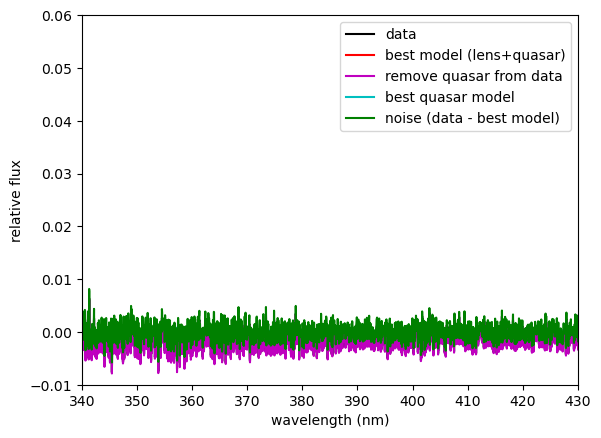

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       539       438
chi2/DOF: 0.007236; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 19; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000697  0.000197
Formal errors:
     dV    dsigma   dh3      dh4
 4.5e+02 4.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       561         0
chi2/DOF: 0.009226; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       152       237
chi2/DOF: 0.01587; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00507    0.0197
Formal errors:
     dV    dsigma   dh3      dh4
      40      43
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       153       243
chi2/DOF: 0.009354; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.008

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       136       232
chi2/DOF: 0.01333; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00335    0.0126
Formal errors:
     dV    dsigma   dh3      dh4
      60      65
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       144       309
chi2/DOF: 0.008077; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.0026

 Best Fit:       Vel     sigma
 comp.  0:      -413         0
chi2/DOF: 0.02743; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 28; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000601    0.0648
Formal errors:
     dV    dsigma   dh3      dh4
      72 5.3e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -139         8
chi2/DOF: 0.05911; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000666    0.0998
Formal errors:
     dV    dsigma   dh3      dh4
      98 3.7e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       160       214
chi2/DOF: 0.01055; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0115   0.00335
Formal errors:
     dV    dsigma   dh3      dh4
      14      15
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       141       267
chi2/DOF: 0.01147; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.01

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       477         0
chi2/DOF: 0.009982; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000518  0.000227
Formal errors:
     dV    dsigma   dh3      dh4
      52 3.3e+03
Elapsed time in pPXF: 0.07 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       173       524
chi2/DOF: 0.02775; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 9; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000515  9.75e-05
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+03 1.2e+03
Elapsed time

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       256         0
chi2/DOF: 0.03955; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000548    0.0784
Formal errors:
     dV    dsigma   dh3      dh4
      97 5.8e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       240       205
chi2/DOF: 0.02782; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00159

 Best Fit:       Vel     sigma
 comp.  0:       166       290
chi2/DOF: 0.008983; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00338   0.00685
Formal errors:
     dV    dsigma   dh3      dh4
      61      66
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       100       316
chi2/DOF: 0.01187; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00308   0.00669
Formal errors:
     dV    dsigma   dh3      dh4
      76      82
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       848       272
chi2/DOF: 0.01235; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00143    0.0219
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+02 1.7e+02
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       697       203
chi2/DOF: 0.01827; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00153    0.0263
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+02 1.3e+02
Elapsed time

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       140       322
chi2/DOF: 0.006726; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00609   0.00358
Formal errors:
     dV    dsigma   dh3      dh4
      32      34
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       181       244
chi2/DOF: 0.01085; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.00

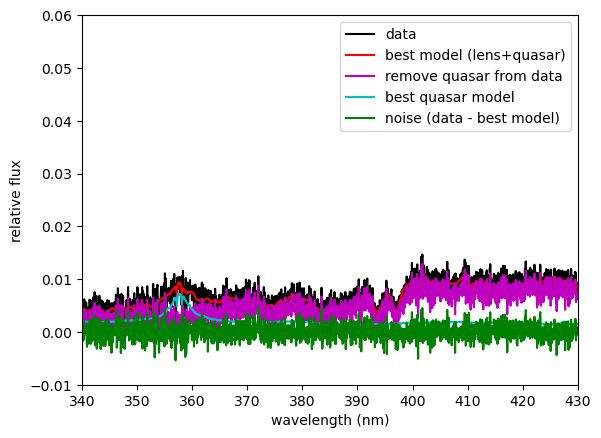

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       133       289
chi2/DOF: 0.009695; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00795   0.00178
Formal errors:
     dV    dsigma   dh3      dh4
      25      27
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       157       291
chi2/DOF: 0.006552; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       249       170
chi2/DOF: 0.006259; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 15; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000506         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.7e+02 1.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       342       185
chi2/DOF: 0.009125; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 15; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -58        31
chi2/DOF: 0.01640; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 19; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00103     0.024
Formal errors:
     dV    dsigma   dh3      dh4
      50      70
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       253       291
chi2/DOF: 0.01320; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00274    0.0107
Formal errors:
     dV    dsigma   dh3      dh4
      82      88
Elapsed time

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       246       339
chi2/DOF: 0.009629; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00338   0.00242
Formal errors:
     dV    dsigma   dh3      dh4
      69      75
Elapsed time in pPXF: 0.05 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       196       263
chi2/DOF: 0.007323; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.002

 Best Fit:       Vel     sigma
 comp.  0:       535         0
chi2/DOF: 0.01079; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 36; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000474   0.00618
Formal errors:
     dV    dsigma   dh3      dh4
      59 3.1e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       520         0
chi2/DOF: 0.008419; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 33; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00042    0.0112
Formal errors:
     dV    dsigma   dh3      dh4
      59 3.6e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        88        76
chi2/DOF: 0.01010; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0023   0.00367
Formal errors:
     dV    dsigma   dh3      dh4
      30      35
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       187       271
chi2/DOF: 0.006173; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00309   0.00307
Formal errors:
     dV    dsigma   dh3      dh4
      48      52
Elapsed tim

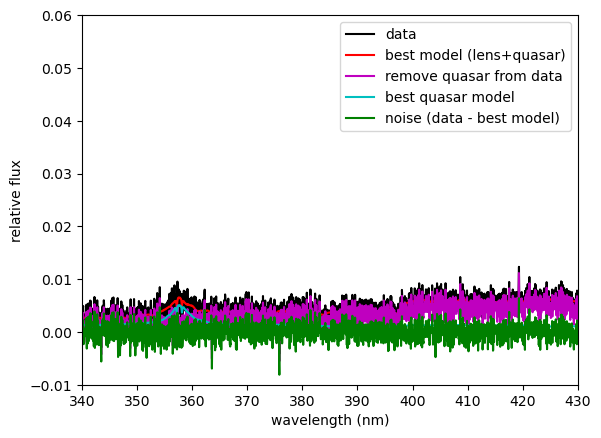

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       103       192
chi2/DOF: 0.008942; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0023    0.0011
Formal errors:
     dV    dsigma   dh3      dh4
      58      63
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       103       192
chi2/DOF: 0.008942; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -543         0
chi2/DOF: 0.008405; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 34; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000489   0.00784
Formal errors:
     dV    dsigma   dh3      dh4
      50 2.9e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -364       666
chi2/DOF: 0.01203; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.0004

 Best Fit:       Vel     sigma
 comp.  0:       215       234
chi2/DOF: 0.01066; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00219   0.00307
Formal errors:
     dV    dsigma   dh3      dh4
      78      83
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       247       241
chi2/DOF: 0.007032; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00268   0.00225
Formal errors:
     dV    dsigma   dh3      dh4
      57      61
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.2548

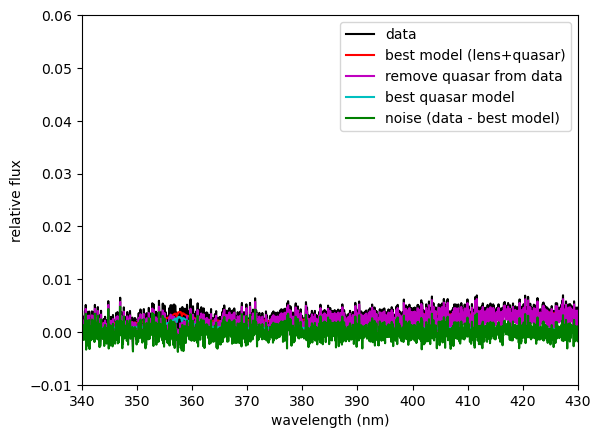

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       181       278
chi2/DOF: 0.009084; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 13; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00073  0.000619
Formal errors:
     dV    dsigma   dh3      dh4
 2.7e+02 2.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        82       291
chi2/DOF: 0.007740; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01139; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0    0.0105
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01048; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0 

 Best Fit:       Vel     sigma
 comp.  0:       243       236
chi2/DOF: 0.009365; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00294  0.000637
Formal errors:
     dV    dsigma   dh3      dh4
      54      58
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       250       226
chi2/DOF: 0.006181; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00264  0.000427
Formal errors:
     dV    dsigma   dh3      dh4
      46      49
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254

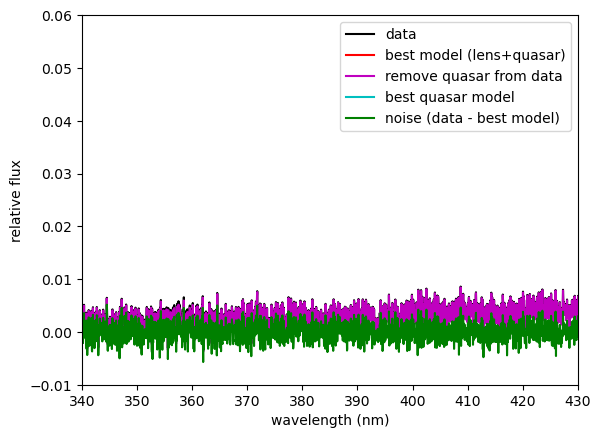

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       263       198
chi2/DOF: 0.008267; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00216  0.000197
Formal errors:
     dV    dsigma   dh3      dh4
      57      63
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       277       307
chi2/DOF: 0.009042; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        91        43
chi2/DOF: 0.008423; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 24; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000344   0.00152
Formal errors:
     dV    dsigma   dh3      dh4
 1.4e+02 1.6e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        33       492
chi2/DOF: 0.01014; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.00098

 Best Fit:       Vel     sigma
 comp.  0:      -115        39
chi2/DOF: 0.01175; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 28; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000615   0.00325
Formal errors:
     dV    dsigma   dh3      dh4
      75      99
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -115        39
chi2/DOF: 0.01175; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 28; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000615   0.00325
Formal errors:
     dV    dsigma   dh3      dh4
      75      99
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        35       494
chi2/DOF: 0.005827; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
   0.00132         0
Formal errors:
     dV    dsigma   dh3      dh4
   2e+02 2.1e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -433       125
chi2/DOF: 0.009217; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000

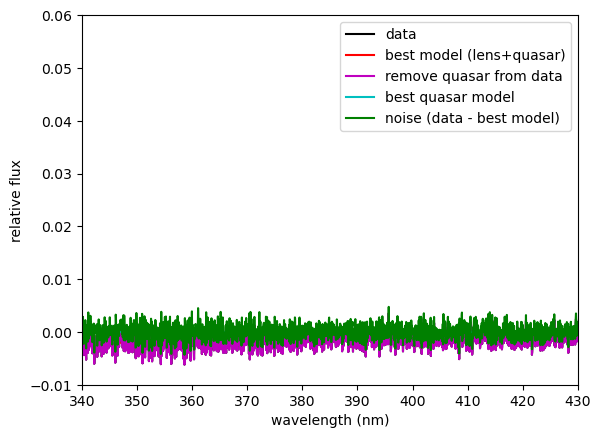

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008516; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.005142; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01148; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000628   0.00397
Formal errors:
     dV    dsigma   dh3      dh4
   3e+02 3.3e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01036; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000627   0.00387
Formal errors:
     dV    dsigma   dh3      dh4
 2.9e+02 3.1e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 

 Best Fit:       Vel     sigma
 comp.  0:      -481       128
chi2/DOF: 0.007275; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 33; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000731  0.000123
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+02 1.4e+02
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -47       314
chi2/DOF: 0.008316; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00121   5.1e-06
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+02 1.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254

 Best Fit:       Vel     sigma
 comp.  0:      -357        99
chi2/DOF: 0.008763; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00062  0.000668
Formal errors:
     dV    dsigma   dh3      dh4
 1.2e+02 1.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -264       148
chi2/DOF: 0.006311; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000584   0.00188
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+02 1.8e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -15       438
chi2/DOF: 0.006721; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 13; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000387  0.000869
Formal errors:
     dV    dsigma   dh3      dh4
 6.2e+02 6.6e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -97       333
chi2/DOF: 0.01111; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.0005

 Best Fit:       Vel     sigma
 comp.  0:       -33         0
chi2/DOF: 0.007316; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000438         0
Formal errors:
     dV    dsigma   dh3      dh4
      52 3.5e+03
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -190         0
chi2/DOF: 0.009141; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000266         0
Formal errors:
     dV    dsigma   dh3      dh4
   1e+02 2.7e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.254

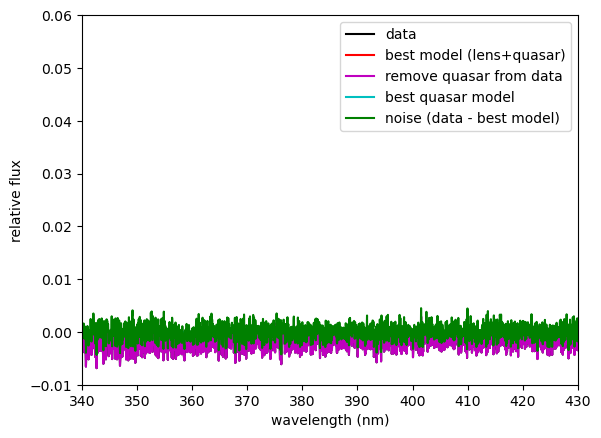

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -215        55
chi2/DOF: 0.008925; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000374  5.46e-05
Formal errors:
     dV    dsigma   dh3      dh4
 1.3e+02 1.6e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -240         0
chi2/DOF: 0.005513; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007086; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00241
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -394       153
chi2/DOF: 0.01034; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.00056

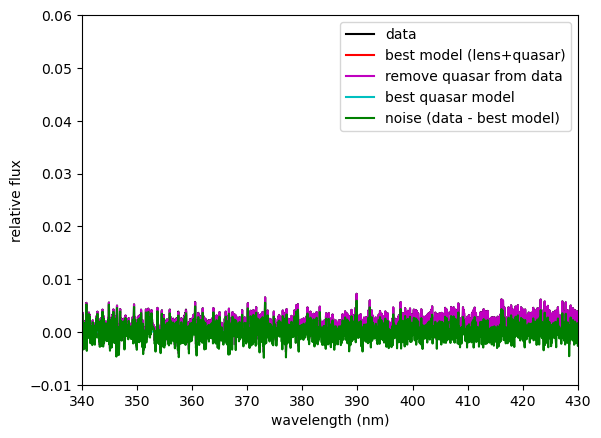

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       271         0
chi2/DOF: 0.007676; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000495  3.26e-05
Formal errors:
     dV    dsigma   dh3      dh4
      47   3e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       283         0
chi2/DOF: 0.008593; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 28; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:        52       588
chi2/DOF: 0.008972; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000202  0.000965
Formal errors:
     dV    dsigma   dh3      dh4
 1.1e+03   9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006516; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   0.00104
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

 Best Fit:       Vel     sigma
 comp.  0:       -19         0
chi2/DOF: 0.007992; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000454  0.000413
Formal errors:
     dV    dsigma   dh3      dh4
      54 2.5e+02
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -28         0
chi2/DOF: 0.01106; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00063  0.000233
Formal errors:
     dV    dsigma   dh3      dh4
      45 3.2e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -117        32
chi2/DOF: 0.006752; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 27; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000409  1.17e-05
Formal errors:
     dV    dsigma   dh3      dh4
      63 1.3e+02
Elapsed time in pPXF: 0.06 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -328       178
chi2/DOF: 0.008734; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000

 Best Fit:       Vel     sigma
 comp.  0:      -153         0
chi2/DOF: 0.009023; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000721   0.00098
Formal errors:
     dV    dsigma   dh3      dh4
      35 2.2e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -157         0
chi2/DOF: 0.006205; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000552    0.0011
Formal errors:
     dV    dsigma   dh3      dh4
      38 2.4e+03
Elapsed time in pPXF: 0.03 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25

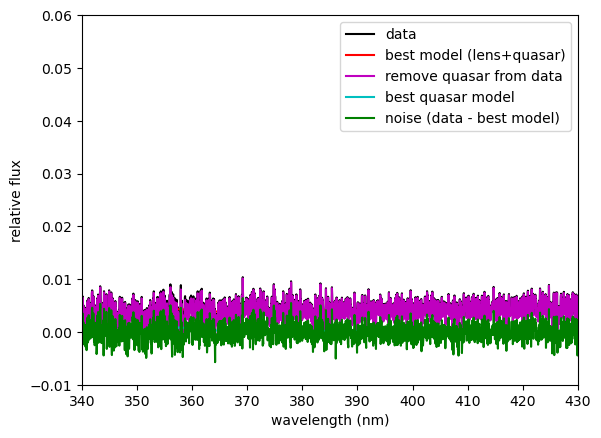

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006654; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  9.65e-06
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.01068; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009749; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007041; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:      -268       248
chi2/DOF: 0.008310; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000377  0.000776
Formal errors:
     dV    dsigma   dh3      dh4
 4.2e+02 4.6e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       211        32
chi2/DOF: 0.008970; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
  0.000507  0.000389
Formal errors:
     dV    dsigma   dh3      dh4
      82 1.1e+02
Elapsed time in pPXF: 0.01 s
CRV

 Best Fit:       Vel     sigma
 comp.  0:         8       173
chi2/DOF: 0.03370; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000463         0
Formal errors:
     dV    dsigma   dh3      dh4
 4.4e+02 5.1e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       224         0
chi2/DOF: 0.01020; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.000329         0
Formal errors:
     dV    dsigma   dh3      dh4
      82   5e+03
Elapsed time in pPXF: 0.06 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487

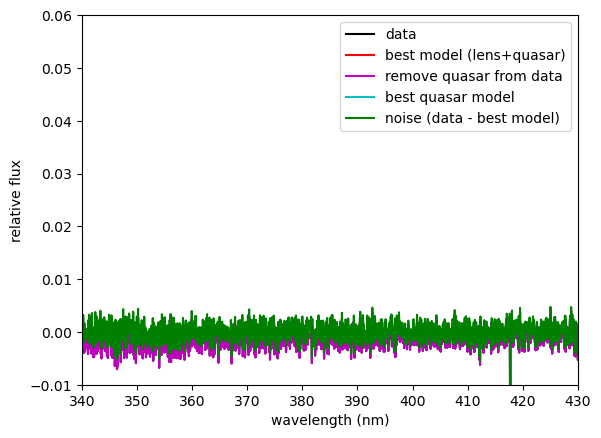

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006027; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  9.22e-05         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.5e+03 9.9e+02
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       -78        37
chi2/DOF: 0.008554; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
  0.0001

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.006167; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0  0.000606
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008617; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008660; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       197         0
chi2/DOF: 0.005447; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 22; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
    0.0003         0
Formal errors:
     dV    dsigma   dh3      dh4
      66 3.7e+03
Elapsed time in pPXF: 0.02 s
CRVA

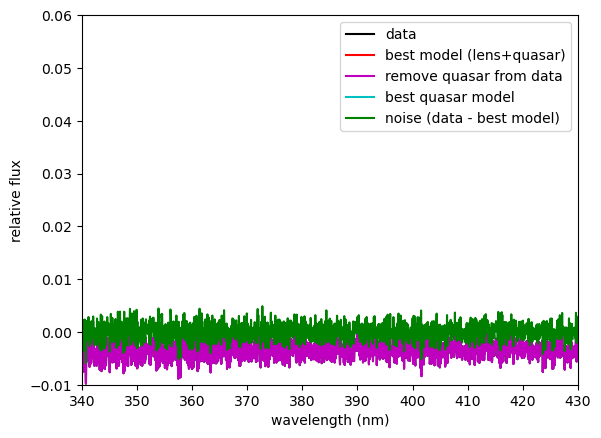

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007138; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.008543; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         

velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009352; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   4.7e-05
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.009352; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
         0   4.7e-05
Formal errors:
     dV    dsigma   dh3 

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       593         0
chi2/DOF: 0.01063; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
   0.00024         0
Formal errors:
     dV    dsigma   dh3      dh4
 1.1e+02 7.5e+03
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:         0       250
chi2/DOF: 0.007186; DOF: 1884; degree = 3; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 5; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 0/2
Templates weights:
         0         0
Formal errors:
     dV    dsigma   dh3      dh4
       0       0
Elapsed time

<Figure size 640x480 with 0 Axes>

In [26]:
data_no_quasar = np.empty_like(data_crop[0].data)
noise_cube = np.empty_like(data_crop[0].data)

for i in range(radius_in_pixels*2+1):
    for j in range(radius_in_pixels*2+1):
        #print (i, j)
        spectrum_perpixel = data_crop[0].data[:,i,j]
        data_no_quasar[:,i,j], noise_cube[:,i,j], sky = remove_quasar_from_galaxy_deredshift(libary_dir, 
                     degree=degree, spectrum_aperture=spectrum_aperture, wave_min=wave_min,
                     wave_max=wave_max, velscale_ratio=velscale_ratio, quasar_spectrum=quasar_spectrum_A,
                     z=z, noise=noise, templates_name='xshooter', FWHM=FWHM_gal,
                     FWHM_tem=FWHM_tem_xshooter, global_temp=global_temp1, plot=False,
                     spectrum_perpixel=spectrum_perpixel, random_plot=True)

In [27]:
## store the data if necessary
hdu_noquasar = hdu.copy()
hdu_noquasar[0].data = data_no_quasar
hdu_noquasar.writeto(dir+name+'_noquasar.fits', overwrite=True)

hdu_noise = hdu.copy()
hdu_noise[0].data = noise_cube
hdu_noise.writeto(dir+name+'_noise.fits', overwrite=True)

### Load the quasar contribution removed data and get a SNR map using restframe wavelength range 3985 - 4085 Ang. In the observed wavelength that is 5160 - 5290 Ang. This region is after Ca H&K and before H-delta lines.

In [28]:
hdu_noquasar = fits.open(dir+name+'_noquasar.fits')
hdu_noise = fits.open(dir+name+'_noise.fits')

data_no_quasar = hdu_noquasar[0].data
noise_cube = hdu_noise[0].data

lin_axis_sky = np.linspace(lamRange1[0], lamRange1[1], data_no_quasar.shape[0])
ind_min = find_nearest(lin_axis_sky, 3985)
ind_max = find_nearest(lin_axis_sky, 4085)
ind_min, ind_max

(3663, 3922)

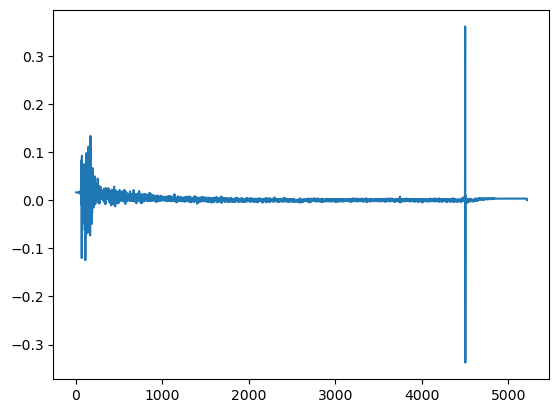

In [29]:
plt.plot(noise_cube[:, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


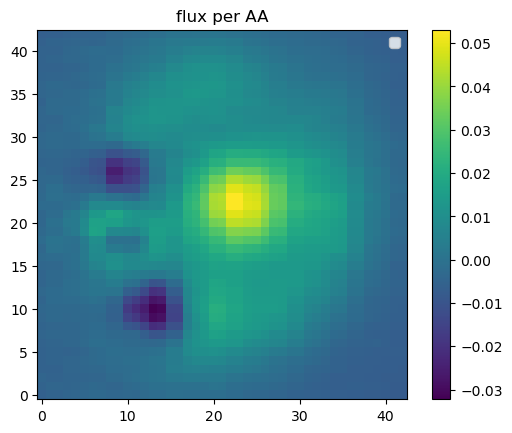

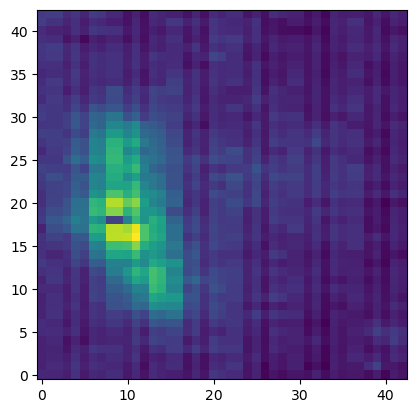

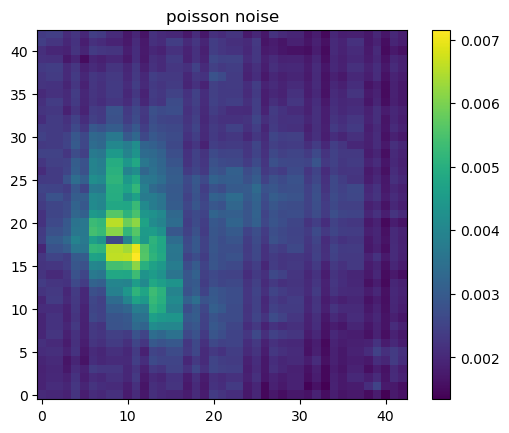

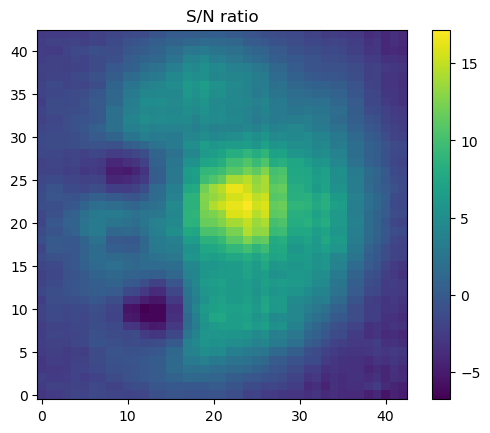

In [30]:
SN_per_AA, flux_per_AA, sigma_poisson = SN_CaHK(ind_min, ind_max, data_no_quasar, noise_cube, T_exp)

### Select a region using the SNR map and a chosen radius and apply voronoi binning to the pixels within that region

In [31]:
def mask_within_radius(arr, x, y, r):
    """
    """
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            d = np.sqrt((x - i)**2 + (y - j)**2)
            if d < r:
                arr[j, i] = 0.
                
    return arr

22 23


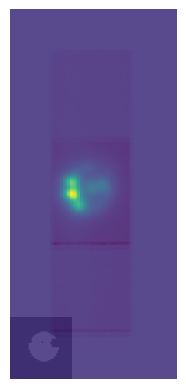

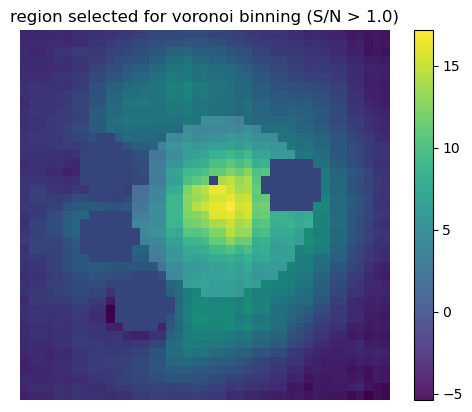

In [32]:
# SN_y_center, SN_x_center = np.unravel_index(SN_per_AA.argmax(), SN_per_AA.shape)
SN_y_center, SN_x_center = int(gal_y), int(gal_x)

SN_per_AA[int(sat_y), int(sat_x)] = 0.

# SN_per_AA[SN_y_center, SN_x_center] = 0.
for a, b in zip(image_x, image_y):
    sigma = 0.98 / 2.355 / 0.1457
    SN_per_AA = mask_within_radius(SN_per_AA, a, b, 1.2 * sigma)


max_radius = 1.5 / 0.1457 # 1.5 arcsec
target_SN = 1.
print(SN_y_center, SN_x_center)

hdu_full = fits.open(dir+name+'.fits')

origin_imaging_data_perAA = np.mean(hdu_full[0].data[ind_min:ind_max,:,:], axis=0)*2

mask = select_region(dir, origin_imaging_data_perAA, SN_per_AA, SN_x_center,
               SN_y_center, radius_in_pixels,
              max_radius, target_SN, name)

minimum S/N within region: 1.404817154497322


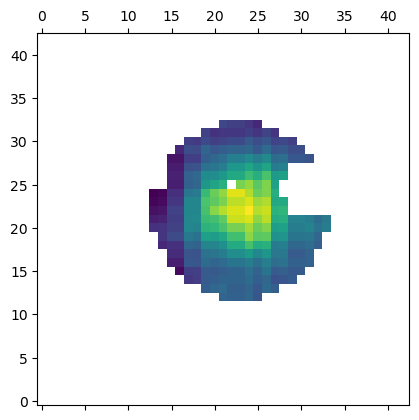

In [33]:
# temp_mask = np.ones_like(SN_per_AA)
#
# temp_mask = mask_within_radius(temp_mask, SN_x_center, SN_y_center, max_radius)
#
# temp_mask2 = 1 - temp_mask
# temp_mask2[25, 14] = 0
a = mask * SN_per_AA
a[a == 0] = np.inf

plt.matshow(a, origin='lower');

# a[25, 14] = 1e10

print('minimum S/N within region:', np.min(a))

#### Convert the pixel coordinates in arcsec unit before binning, then perform binning using pixel coordinates in arcsec unit and after binning bring them back to cartesian coordinates.

In [34]:
x, y, signal, noise = np.loadtxt(dir+'voronoi_2d_binning_'+name+'_input.txt').T

x -= SN_x_center
y -= SN_y_center
x *= 0.1457 # pixel scale of the KCWI data
y *= 0.1457

vor_input = np.vstack((x, y, signal, noise)).T
np.savetxt(dir + 'voronoi_2d_binning_' + name + '_arcsec_input.txt', vor_input,
               fmt=b'%10.6f %10.6f %10.6f %10.6f')

In [35]:
x, y, signal, noise = np.loadtxt(dir+'voronoi_2d_binning_'+name+'_input.txt').T

for a, b in zip(x, y):
    print(a, b)

21.0 12.0
22.0 12.0
23.0 12.0
24.0 12.0
25.0 12.0
19.0 13.0
20.0 13.0
21.0 13.0
22.0 13.0
23.0 13.0
24.0 13.0
25.0 13.0
26.0 13.0
27.0 13.0
17.0 14.0
18.0 14.0
19.0 14.0
20.0 14.0
21.0 14.0
22.0 14.0
23.0 14.0
24.0 14.0
25.0 14.0
26.0 14.0
27.0 14.0
28.0 14.0
29.0 14.0
16.0 15.0
17.0 15.0
18.0 15.0
19.0 15.0
20.0 15.0
21.0 15.0
22.0 15.0
23.0 15.0
24.0 15.0
25.0 15.0
26.0 15.0
27.0 15.0
28.0 15.0
29.0 15.0
30.0 15.0
15.0 16.0
16.0 16.0
17.0 16.0
18.0 16.0
19.0 16.0
20.0 16.0
21.0 16.0
22.0 16.0
23.0 16.0
24.0 16.0
25.0 16.0
26.0 16.0
27.0 16.0
28.0 16.0
29.0 16.0
30.0 16.0
31.0 16.0
15.0 17.0
16.0 17.0
17.0 17.0
18.0 17.0
19.0 17.0
20.0 17.0
21.0 17.0
22.0 17.0
23.0 17.0
24.0 17.0
25.0 17.0
26.0 17.0
27.0 17.0
28.0 17.0
29.0 17.0
30.0 17.0
31.0 17.0
14.0 18.0
15.0 18.0
16.0 18.0
17.0 18.0
18.0 18.0
19.0 18.0
20.0 18.0
21.0 18.0
22.0 18.0
23.0 18.0
24.0 18.0
25.0 18.0
26.0 18.0
27.0 18.0
28.0 18.0
29.0 18.0
30.0 18.0
31.0 18.0
32.0 18.0
14.0 19.0
15.0 19.0
16.0 19.0
17.0 19.0
18.0 19.0


### Bin the pixels using target SNs

In [36]:
snr_1 = 23
snr_2 = 28

Bin-accretion...
1  /  43
2  /  43
3  /  43
4  /  43
5  /  43
6  /  43
7  /  43
8  /  43
9  /  43
10  /  43
11  /  43
12  /  43
13  /  43
14  /  43
15  /  43
16  /  43
17  /  43
18  /  43
19  /  43
20  /  43
21  /  43
22  /  43
23  /  43
24  /  43
25  /  43
26  /  43
27  /  43
28  /  43
29  /  43
30  /  43
31  /  43
32  /  43
33  /  43
34  /  43
35  /  43
36  /  43
37  /  43
38  /  43
39  /  43
40  /  43
41  /  43
42  /  43
43  /  43
44  /  43
45  /  43
46  /  43
47  /  43
48  /  43
49  /  43
50  /  43
51  /  43
52  /  43
52  initial bins.
Reassign bad bins...
41  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 1.91
Iter:    2  Diff: 0.914
Iter:    3  Diff: 0.5297
Iter:    4  Diff: 0.152
Iter:    5  Diff: 0.1777
Iter:    6  Diff: 0
5  iterations.
Unbinned pixels:  0  /  302
Fractional S/N scatter (%): 10.291763407171963
Elapsed time accretion: 0.01 seconds
Elapsed time optimization: 0.00 seconds


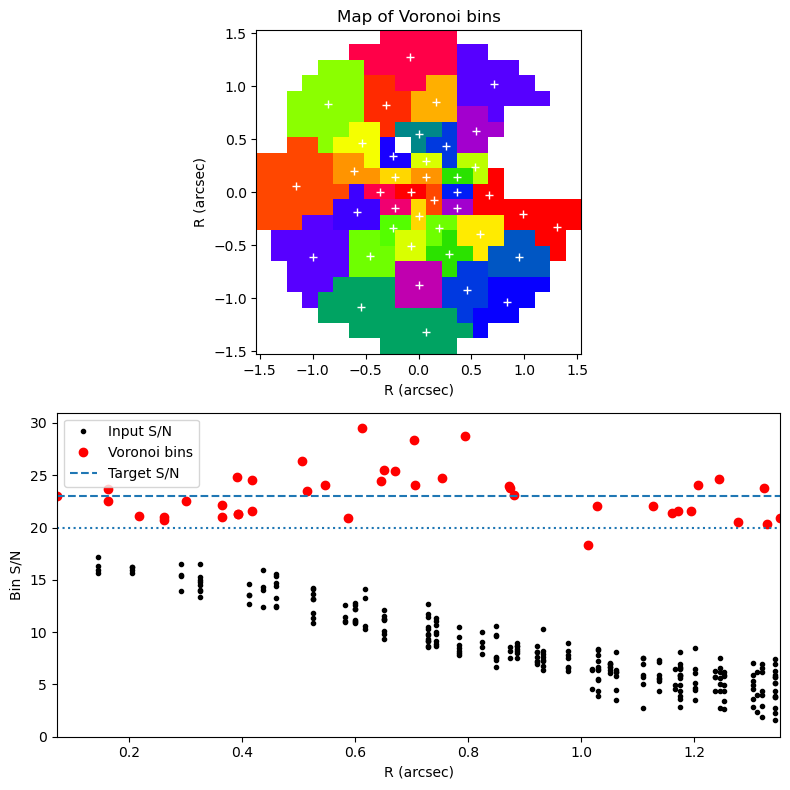

In [37]:
bin_target_SN = snr_1
plt.figure(figsize=(8, 8))
voronoi_binning(bin_target_SN, dir, name+'_arcsec')
plt.axhline(20, ls=':')
plt.tight_layout()
plt.pause(1)

In [38]:
# convert back to cartesian coordiantes
output = np.loadtxt(dir +'voronoi_2d_binning_' + name+ '_arcsec_output.txt')

x, y, binNum = output.T[0], output.T[1], output.T[2]

x = x / 0.1457 + SN_x_center
y = y / 0.1457 + SN_y_center

np.savetxt(dir+'voronoi_2d_binning_'+ name +'_targetSN_{}_output.txt'.format(snr_1), \
                      np.column_stack([x, y, binNum]),fmt=b'%10.6f %10.6f %8i')

Bin-accretion...
1  /  29
2  /  29
3  /  29
4  /  29
5  /  29
6  /  29
7  /  29
8  /  29
9  /  29
10  /  29
11  /  29
12  /  29
13  /  29
14  /  29
15  /  29
16  /  29
17  /  29
18  /  29
19  /  29
20  /  29
21  /  29
22  /  29
23  /  29
24  /  29
25  /  29
26  /  29
27  /  29
28  /  29
29  /  29
30  /  29
31  /  29
32  /  29
33  /  29
34  /  29
35  /  29
35  initial bins.
Reassign bad bins...
27  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 2.7
Iter:    2  Diff: 0.6312
Iter:    3  Diff: 0.428
Iter:    4  Diff: 0.3078
Iter:    5  Diff: 0
4  iterations.
Unbinned pixels:  0  /  302
Fractional S/N scatter (%): 12.89217130360661
Elapsed time accretion: 0.02 seconds
Elapsed time optimization: 0.00 seconds


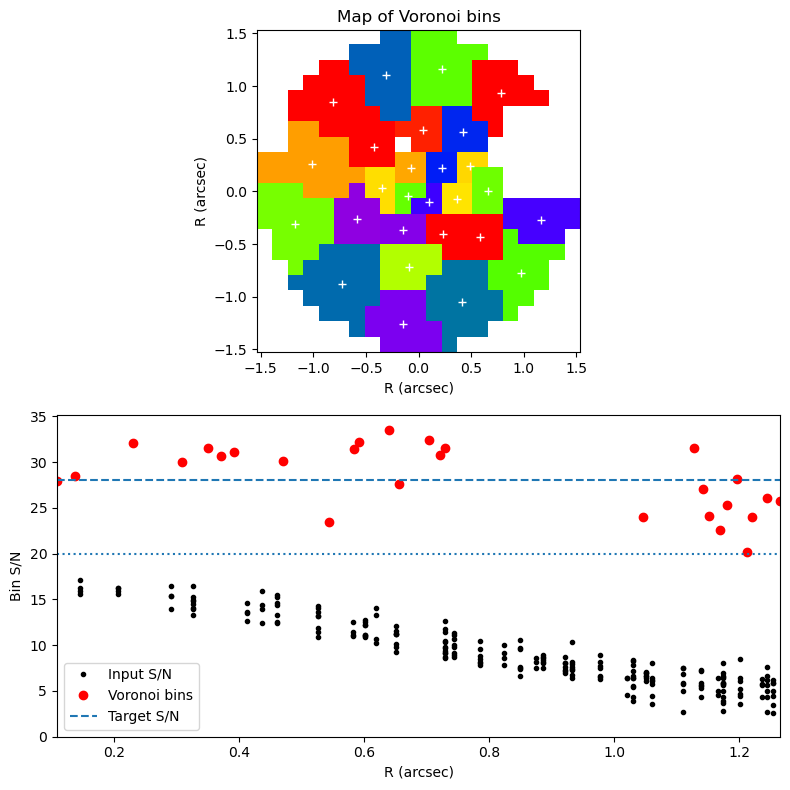

In [39]:
bin_target_SN = snr_2
plt.figure(figsize=(8, 8))
voronoi_binning(bin_target_SN, dir, name+'_arcsec')
plt.axhline(20, ls=':')
plt.tight_layout()
plt.pause(1)

In [40]:
# convert back to cartesian coordiantes
output = np.loadtxt(dir +'voronoi_2d_binning_' + name+ '_arcsec_output.txt')

x, y, binNum = output.T[0], output.T[1], output.T[2]

x = x / 0.1457 + SN_x_center
y = y / 0.1457 + SN_y_center

np.savetxt(dir+'voronoi_2d_binning_'+ name +'_targetSN_{}_output.txt'.format(snr_2), \
                      np.column_stack([x, y, binNum]),fmt=b'%10.6f %10.6f %8i')

### Now bin the data using the voronoi binning map

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

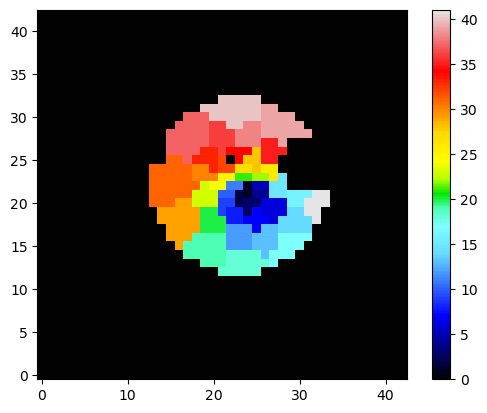

In [41]:
get_voronoi_binning_data(dir, name, name+'_targetSN_{}'.format(snr_1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

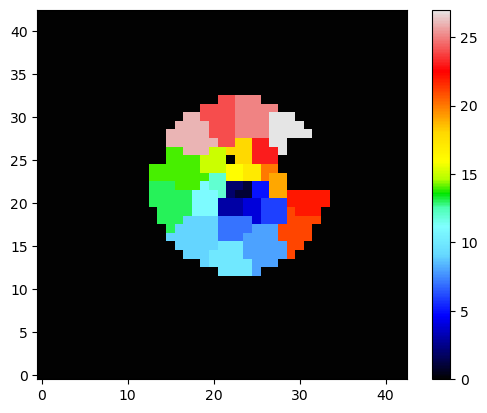

In [42]:
get_voronoi_binning_data(dir, name, name+'_targetSN_{}'.format(snr_2))

### Measure the kinematics

In [43]:
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_targetSN_{}'.format(snr_1) + '_data.fits')

get_velocity_dispersion_deredshift(degree=degree,
                                   spectrum_aperture=spectrum_aperture,
                                   voronoi_binning_data=voronoi_binning_data,
                                   velscale_ratio=velscale_ratio,
                                   z=z, noise=noise, FWHM=FWHM_gal,
                                   FWHM_tem_xshooter=FWHM_tem_xshooter,
                                   dir=dir, libary_dir=libary_dir,
                                   global_temp=global_temp1,
                                   quasar_spectrum=quasar_spectrum_A,
                                   wave_min=wave_min, wave_max=wave_max,
                                   T_exp=T_exp, VD_name='targetSN_{}'.format(snr_1),
                                   plot=False)

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       191       282
chi2/DOF: 5.295e-06; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0512     0.007
Formal errors:
     dV    dsigma   dh3      dh4
     6.5       7
Elapsed time in pPXF: 0.02 s
[nan] 7.030847812906875e-06
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       192       282
chi2/DOF: 0.5432; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       190       274
chi2/DOF: 1.046e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.058    0.0154
Formal errors:
     dV    dsigma   dh3      dh4
     7.8     8.4
Elapsed time in pPXF: 0.01 s
[nan] 1.3107482336997495e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       191       274
chi2/DOF: 0.6227; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       168       278
chi2/DOF: 6.405e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0438   0.00961
Formal errors:
     dV    dsigma   dh3      dh4
      26      28
Elapsed time in pPXF: 0.01 s
[nan] 7.383625398306227e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       168       278
chi2/DOF: 0.8143; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2

 Best Fit:       Vel     sigma
 comp.  0:       179       286
chi2/DOF: 1.261e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0519    0.0232
Formal errors:
     dV    dsigma   dh3      dh4
      10      11
Elapsed time in pPXF: 0.01 s
[nan] 1.544523195963043e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       179       286
chi2/DOF: 0.6405; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.052    0.0232
Formal errors:
     dV    dsigma   dh3      dh4
      10      11
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
vels

h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       178       267
chi2/DOF: 2.289e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0781    0.0121
Formal errors:
     dV    dsigma   dh3      dh4
     8.4       9
Elapsed time in pPXF: 0.01 s
[nan] 2.8096513665513512e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       178       266
chi2/DOF: 0.7106; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0781     0.012
Formal errors:
     dV    dsigma   dh3      dh4

<Figure size 640x480 with 0 Axes>

In [44]:
measurements = np.loadtxt(dir + 'VD_%s.txt' % 'targetSN_{}'.format(snr_1))
measurements.shape

(41, 4)

### The bins with a velocity dispersion value > 350 or < 150 have been excluded and filled with 'NaN'. The number of those bins are printed below.¶

In [45]:
for i in range(measurements.shape[0]):
    if measurements[i][1] > 350 or measurements[i][1] < 150:
        print(i) # excluded bins
        measurements[i][0], measurements[i][1] = np.nan, np.nan
        measurements[i][2], measurements[i][3] = np.nan, np.nan
        
np.savetxt(dir + 'VD_%s_excluding_bins.txt' % 'targetSN_{}'.format(snr_1), measurements, fmt='%1.4e')

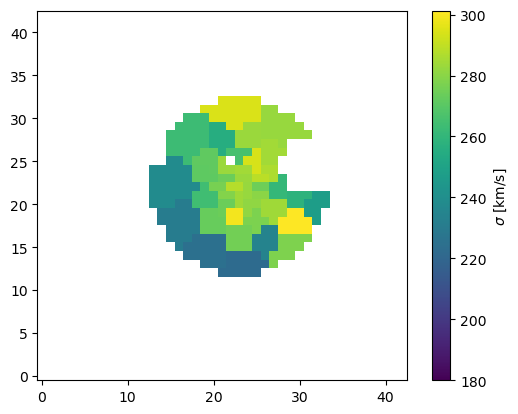

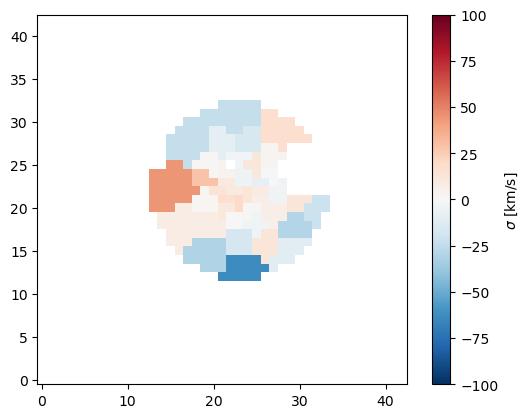

In [46]:
## kinematics map after excluding few bins and filling them with nan
VD_2d, dVD_2d, V_2d, dV_2d = kinematics_map(dir, name +'_targetSN_{}'.format(snr_1), radius_in_pixels=21,
                                            VD_name='targetSN_{}_excluding_bins'.format(snr_1), vd_val=1000)

plt.imshow(VD_2d, origin='lower', cmap='viridis', vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

plt.imshow(V_2d - 180, origin='lower', cmap='RdBu_r', vmax=100, vmin=-100) #, vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

In [47]:

## kinematics for bins with target SN 26
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_targetSN_{}'.format(snr_2) + '_data.fits')

get_velocity_dispersion_deredshift(degree=degree,
                                   spectrum_aperture=spectrum_aperture,
                                   voronoi_binning_data=voronoi_binning_data,
                                   velscale_ratio=velscale_ratio,
                                   z=z, noise=noise, FWHM=FWHM_gal,
                                   FWHM_tem_xshooter=FWHM_tem_xshooter,
                                   dir=dir, libary_dir=libary_dir,
                                   global_temp=global_temp1,
                                   quasar_spectrum=quasar_spectrum_A,
                                   wave_min=wave_min, wave_max=wave_max,
                                   T_exp=T_exp, VD_name='targetSN_{}'.format(snr_2),
                                   plot=False)

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       197       282
chi2/DOF: 1.154e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0781    0.0111
Formal errors:
     dV    dsigma   dh3      dh4
     6.3     6.8
Elapsed time in pPXF: 0.02 s
[nan] 1.5189354253773346e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       198       282
chi2/DOF: 0.5964; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/

[nan] 0.00039134846005604114
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       175       239
chi2/DOF: 0.9617; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
      0.12     0.496
Formal errors:
     dV    dsigma   dh3      dh4
      21      23
Elapsed time in pPXF: 0.01 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       130       205
chi2/DOF: 0.0001382; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/

 Best Fit:       Vel     sigma
 comp.  0:       180       292
chi2/DOF: 1.113e-05; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0569    0.0208
Formal errors:
     dV    dsigma   dh3      dh4
     8.8     9.5
Elapsed time in pPXF: 0.02 s
[nan] 1.4542599338306536e-05
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1388 1389 1390 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       180       292
chi2/DOF: 0.5917; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
     0.057    0.0208
Formal errors:
     dV    dsigma   dh3      dh4
     8.9     9.5
Elapsed time in pPXF: 0.02 s
CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
vel

<Figure size 640x480 with 0 Axes>

In [48]:
measurements = np.loadtxt(dir + 'VD_%s.txt' % 'targetSN_{}'.format(snr_2))
measurements.shape

(27, 4)

### The bins with a velocity dispersion value > 350 or < 150 have been excluded and filled with 'NaN'. The number of those bins are printed below.

In [49]:
for i in range(measurements.shape[0]):
    if measurements[i][1] > 350 or measurements[i][1] < 150:
        print(i) # excluded bins
        measurements[i][0], measurements[i][1] = np.nan, np.nan
        measurements[i][2], measurements[i][3] = np.nan, np.nan
        
np.savetxt(dir + 'VD_%s_excluding_bins.txt' % 'targetSN_{}'.format(snr_2), measurements, fmt='%1.4e')

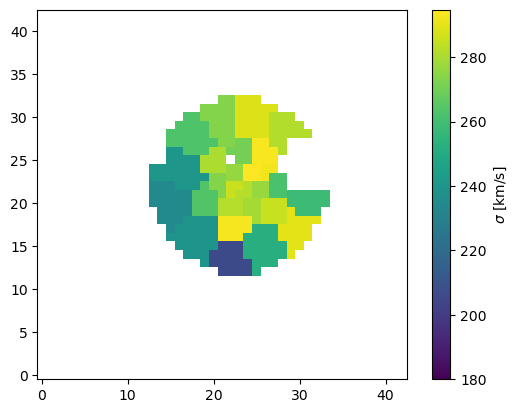

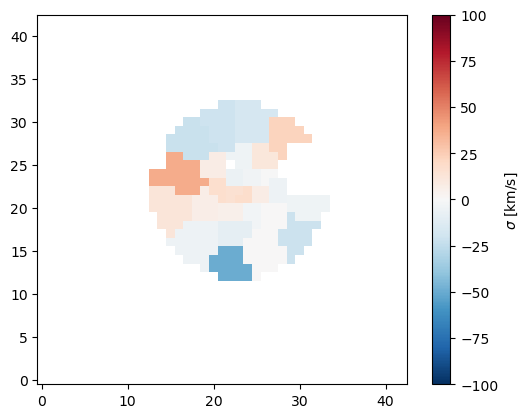

In [50]:
VD_2d, dVD_2d, V_2d, dV_2d = kinematics_map(dir, name+'_targetSN_{}'.format(snr_2), radius_in_pixels=21,
                                            VD_name='targetSN_{}_excluding_bins'.format(snr_2), vd_val=1000)

plt.imshow(VD_2d, origin='lower', cmap='viridis', vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

plt.imshow(V_2d - 180, origin='lower', cmap='RdBu_r', vmax=100, vmin=-100) #, vmin=180)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ [km/s]')
plt.show()

In [51]:
VD_2d.shape

(43, 43)

### Check systematics

In [51]:
wavelength_list = [['rng_1', 0.34, 0.43], ['rng_2', 0.335, 0.425], ['rng_3', 0.33, 0.42]]
deg_list = [2, 3, 4]
global_temp_list = [global_temp1, global_temp2, global_temp3]
quasar_list = [quasar_spectrum_A, quasar_spectrum_B, quasar_spectrum_C]

In [ ]:
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_targetSN_{}'.format(snr_1) + '_data.fits')

for w in wavelength_list:
    wv_min, wv_max = w[1], w[2]
    for d in deg_list:
        deg = d
        for i, gt in enumerate(global_temp_list):
            global_tmp = gt
            for j, qsp in enumerate(quasar_list):
                quasar_spec = qsp
                qsp_name = chr(j+65)
                
                vd_name = 'wave_{}_deg_{}_global_temp_{}_quasar_sp_{}_SN_{}'.format(w[0], deg, i+1, qsp_name, snr_1)
                get_velocity_dispersion_deredshift(degree=deg,
                                   spectrum_aperture=spectrum_aperture,
                                   voronoi_binning_data=voronoi_binning_data,
                                   velscale_ratio=velscale_ratio,
                                   z=z, noise=noise, FWHM=FWHM_gal,
                                   FWHM_tem_xshooter=FWHM_tem_xshooter,
                                   dir=dir, libary_dir=libary_dir,
                                   global_temp=global_tmp,
                                   quasar_spectrum=quasar_spec,
                                   wave_min=wv_min, wave_max=wv_max,
                                   T_exp=T_exp, VD_name=vd_name,
                                   plot=False, verbose=False, quiet=True)
            
                ## just to check
                print('VD_wave_{}_deg_{}_global_temp_{}_quasar_sp_{}'.format(w[0], deg, i+1, qsp_name))
                ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=deg,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wv_min, wave_max=wv_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z, noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spec,
                                                      plot=True, global_template_lens=global_tmp,
                                                spectrum_perpixel=voronoi_binning_data[0])
                plt.show()